In [17]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot       as plt
import seaborn                 as sns

import pandas                  as pd
from pandas_profiling          import ProfileReport
import numpy                   as np
from sklearn.model_selection   import train_test_split
from sklearn.base              import BaseEstimator, TransformerMixin
from sklearn.metrics           import classification_report, f1_score
from sklearn                   import set_config
from sklearn                   import datasets
from sklearn                   import ensemble, neighbors,linear_model,svm
from scipy.stats               import zscore
from IPython.utils             import io
import eli5

set_config(display='diagram')
#datasets.load*?

In [18]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target']  = pd.Series(sklearn_dataset.target)
    return df

In [105]:
#df = sklearn_to_df(datasets.load_wine())
#df = pd.read_pickle('output/load_wine/03 Feature_Selection_load_wine')
df = pd.read_pickle('output/load_wine/04 Kmeans_3')
#df = pd.read_pickle('output/load_wine/04 Kmeans3_pca5')
#df = pd.read_pickle('output/load_wine/04 PCA_5')
target = 'target'
drop_columns = []

In [106]:
df.head()

alcohol  alcalinity_of_ash  nonflavanoid_phenols  proanthocyanins  \
0  1.518613          -1.169593             -0.659563         1.224884   
1  0.246290          -2.490847             -0.820719        -0.544721   
2  0.196879          -0.268738             -0.498407         2.135968   
3  1.691550          -0.809251             -0.981875         1.032155   
4  0.295700           0.451946              0.226796         0.401404   

        hue   proline  kmean_clust  target  
0  0.362177  1.013009            2       0  
1  0.406051  0.965242            2       0  
2  0.318304  1.395148            2       0  
3 -0.427544  2.334574            2       0  
4  0.362177 -0.037874            0       0

In [107]:
# Input_df = pd.read_csv('input/pima.csv')
# target = 'class'
# drop_columns = ['skin','Pres']
# df = Input_df.drop(drop_columns, axis = 1)

In [108]:
if df[target].dtypes == np.object:    
    numeric_features      = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features  = df.select_dtypes(include=['object']).drop(target, axis=1).columns
else:
    numeric_features      = df.select_dtypes(include=['int64', 'float64']).drop(target, axis=1).columns
    categorical_features  = df.select_dtypes(include=['object']).columns
    
X = df.drop((target),axis = 'columns')
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.3,random_state =1)

In [109]:
#ProfileReport(df)

In [110]:
# train_values = pd.read_csv('train_values.csv')
# train_labels = pd.read_csv('train_labels.csv')
# train_data = train_values.merge(train_labels, left_on='building_id', right_on='building_id')

# train_data = train_data.drop('building_id', axis=1)
# numeric_features = train_data.select_dtypes(include=['int64', 'float64']).drop(['damage_grade'], axis=1).columns
# categorical_features = train_data.select_dtypes(include=['object']).columns
# X = train_data.drop('damage_grade', axis=1)
# y = train_data['damage_grade']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [111]:
from sklearn.pipeline           import Pipeline
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import OneHotEncoder,StandardScaler,PolynomialFeatures,MinMaxScaler
from sklearn.compose            import ColumnTransformer
from sklearn                    import ensemble, neighbors,linear_model,svm
from sklearn.feature_selection  import SelectFromModel
from sklearn.model_selection    import cross_val_score
from sklearn.decomposition      import PCA


numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    #('feature_selection',SelectFromModel(svm.LinearSVC(penalty = 'l1',dual = False))),
    #('scaler', StandardScaler()),
    #('scaler',MinMaxScaler()),
    ('poly', PolynomialFeatures(degree = 2,interaction_only = True)),
    #('PCA_decomposition', PCA(n_components = 3))
    ])
categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='most_frequent')),
    ('one_hot', OneHotEncoder()),
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model',  ensemble.RandomForestRegressor(max_depth = 3))])
    
#model = pipe.fit(X_train, y_train)
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(interaction_only=True))]),
                                                  Index(['alcohol', 'alcalinity_of_ash', 'nonflavanoid_phenols',
       'proanthocyanins', 'hue', 'proline'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  Index([], dtype='object'))])),
                ('model', RandomForestRegressor(max_depth=3))])

In [112]:
model_list = [#regressors
                linear_model.LinearRegression(),linear_model.Lasso(),linear_model.Ridge(),svm.SVR(),
              
              #ensembling - regressors
                ensemble.RandomForestRegressor(max_depth = 3),ensemble.AdaBoostRegressor(),ensemble.GradientBoostingRegressor(),
    
              #classifiers
                linear_model.LogisticRegression(max_iter = 500), neighbors.KNeighborsClassifier(),svm.SVC(),             
    
              #ensembling - classifiers
                ensemble.RandomForestClassifier(n_estimators=500,max_depth = 3),ensemble.AdaBoostClassifier(learning_rate=0.5),ensemble.GradientBoostingClassifier(n_estimators = 200)

              ]

In [120]:
def test_models(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.3,random_state =1)
    rejected_models = []
    results = []
    print('{:30s}Train  /  Test   /  Cross Validation'.format('Model'))
    print('-----------------------------------------------------------------')
    for model in model_list:
        pipe                 = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
        try:        
            with io.capture_output() as captured:
                pipe.fit(X_train,y_train);
            model_name       = type(model).__name__
            train_results    = np.abs(pipe.score(X_train,y_train))
            test_results     = np.abs(pipe.score(X_test,y_test))
            cross_val_scores = np.abs(cross_val_score(pipe, X, y, cv=5)) 
            cval_score       = cross_val_scores.mean()

            results.append([model_name, train_results, test_results,cval_score])
            print('{:30s}{:.4f} / {:.4f}  /  {:.4f} '.format(model_name, train_results, test_results,cval_score))

        except:
            rejected_models.append(type(model).__name__)

    df_results = pd.DataFrame(results, columns=["Model", "Train Results","Test Results",'Test Cross Validation Results'])
    
    print('\n')
    if rejected_models == []:
        print('No models rejected')
    else:    
        print('Rejected Models list: ')
        for rej_models in rejected_models:
            print('  - ',rej_models)
    return df_results

In [118]:
# print('\n')
# if rejected_models == []:
#     print('No models rejected')
# else:    
#     print('Rejected Models list: ')
#     for rej_models in rejected_models:
#         print('  - ',rej_models)

In [124]:
df = sklearn_to_df(datasets.load_wine())
#df = pd.read_pickle('output/load_wine/03 Feature_Selection_load_wine')
#df = pd.read_pickle('output/load_wine/04 Kmeans_3')
#df = pd.read_pickle('output/load_wine/04 Kmeans3_pca5')
#df = pd.read_pickle('output/load_wine/04 PCA_5')

X = df.drop((target),axis = 'columns')
y = df[target]
df_result1 = test_models(X,y)
df_result1['data'] = 'original'

Model                         Train  /  Test   /  Cross Validation
-----------------------------------------------------------------
LinearRegression              0.8372 / 0.7821  /  0.1079 
Lasso                         0.7466 / 0.5748  /  0.0895 
Ridge                         0.8167 / 0.7164  /  0.0863 
SVR                           0.4836 / 0.5870  /  0.1477 
RandomForestRegressor         0.9574 / 0.8463  /  0.1826 
AdaBoostRegressor             1.0000 / 0.9191  /  0.2790 
GradientBoostingRegressor     0.9998 / 0.7522  /  0.1580 
LogisticRegression            1.0000 / 0.9815  /  0.9497 
KNeighborsClassifier          0.8710 / 0.8148  /  0.7979 
SVC                           0.7500 / 0.7407  /  0.7422 
RandomForestClassifier        0.9839 / 0.9444  /  0.9102 
AdaBoostClassifier            0.9758 / 0.9259  /  0.8654 
GradientBoostingClassifier    1.0000 / 0.9630  /  0.8992 


No models rejected


In [125]:
df.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0                          3.92   1065.0       0  
1                          3.40   1050.0       0  
2                          3.17   1185.0       0  
3                          3.45   1480.0       0  
4                          2.93    735.0       0

In [126]:
#df = sklearn_to_df(datasets.load_wine())
df = pd.read_pickle('output/load_wine/03 Feature_Selection_load_wine')
#df = pd.read_pickle('output/load_wine/04 Kmeans_3')
#df = pd.read_pickle('output/load_wine/04 Kmeans3_pca5')
#df = pd.read_pickle('output/load_wine/04 PCA_5')

X = df.drop((target),axis = 'columns')
y = df[target]
df_result2 = test_models(X,y)
df_result2['data'] = 'selected_features'

Model                         Train  /  Test   /  Cross Validation
-----------------------------------------------------------------
LinearRegression              0.8372 / 0.7821  /  0.1079 
Lasso                         0.7466 / 0.5748  /  0.0895 
Ridge                         0.8167 / 0.7164  /  0.0863 
SVR                           0.4836 / 0.5870  /  0.1477 
RandomForestRegressor         0.9576 / 0.8384  /  0.1988 
AdaBoostRegressor             0.9999 / 0.9155  /  0.2288 
GradientBoostingRegressor     0.9998 / 0.7465  /  0.1589 
LogisticRegression            1.0000 / 0.9815  /  0.9497 
KNeighborsClassifier          0.8710 / 0.8148  /  0.7979 
SVC                           0.7500 / 0.7407  /  0.7422 
RandomForestClassifier        0.9839 / 0.9259  /  0.9157 
AdaBoostClassifier            0.9758 / 0.9259  /  0.8710 
GradientBoostingClassifier    1.0000 / 0.9630  /  0.8992 


No models rejected


In [129]:
#df = sklearn_to_df(datasets.load_wine())
#df = pd.read_pickle('output/load_wine/03 Feature_Selection_load_wine')
df = pd.read_pickle('output/load_wine/04 Kmeans_3')
#df = pd.read_pickle('output/load_wine/04 Kmeans3_pca5')
#df = pd.read_pickle('output/load_wine/04 PCA_5')

X = df.drop((target),axis = 'columns')
y = df[target]
df_result3 = test_models(X,y)
df_result3['data'] = 'selected_features'

Model                         Train  /  Test   /  Cross Validation
-----------------------------------------------------------------
LinearRegression              0.8372 / 0.7821  /  0.1079 
Lasso                         0.0000 / 0.0684  /  0.7028 
Ridge                         0.8372 / 0.7838  /  0.1113 
SVR                           0.9594 / 0.8865  /  0.2434 
RandomForestRegressor         0.9448 / 0.8409  /  0.0511 
AdaBoostRegressor             0.9998 / 0.9187  /  0.2512 
GradientBoostingRegressor     0.9997 / 0.8463  /  0.1025 
LogisticRegression            0.9839 / 0.9630  /  0.9386 
KNeighborsClassifier          0.9758 / 0.9815  /  0.9610 
SVC                           0.9677 / 0.9630  /  0.9106 
RandomForestClassifier        0.9919 / 0.9444  /  0.8881 
AdaBoostClassifier            0.9758 / 0.9444  /  0.9103 
GradientBoostingClassifier    1.0000 / 0.9444  /  0.8770 


No models rejected


In [140]:
#df = sklearn_to_df(datasets.load_wine())
#df = pd.read_pickle('output/load_wine/03 Feature_Selection_load_wine')
#df = pd.read_pickle('output/load_wine/04 Kmeans_3')
#df = pd.read_pickle('output/load_wine/04 Kmeans3_pca5')
df = pd.read_pickle('output/load_wine/04 PCA_5')

In [141]:
df

0         1         2         3         4  target
0    2.453834 -0.478830 -0.308884  0.080246 -0.413800       0
1    1.943895 -0.210087  1.821981 -0.861821 -0.556337       0
2    2.007374  0.475622 -1.338303  0.520638 -0.547169       0
3    2.872079 -1.407771 -0.772099 -0.127511  0.070277       0
4    0.058450  0.109140 -0.405045  0.579370  0.151152       0
..        ...       ...       ...       ...       ...     ...
173 -1.080631 -2.000390  0.044032  0.191181 -0.260355       2
174 -0.943215 -1.196691 -0.787832  0.087896  0.275952       2
175 -0.648045 -1.504925 -0.360288 -0.384414 -0.371404       2
176 -0.928988 -1.574974 -0.352159  0.240568 -0.843978       2
177 -1.689106 -2.124711 -1.054940  0.682333  0.045559       2

[178 rows x 6 columns]

In [140]:
if df[target].dtypes == np.object:    
    numeric_features      = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features  = df.select_dtypes(include=['object']).drop(target, axis=1).columns
else:
    numeric_features      = df.select_dtypes(include=['int64', 'float64']).drop(target, axis=1).columns
    categorical_features  = df.select_dtypes(include=['object']).columns

X = df.drop((target),axis = 'columns')
y = df[target]
#df_result4 = test_models(X,y)
df_results = check_model(X,y)
df_result4['data'] = 'selected_features'

Model                         Train  /  Test   /  Cross Validation
-----------------------------------------------------------


ValueError: A given column is not a column of the dataframe

In [115]:
def highlight_range(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    #threshold = 0.95
    #val = s > threshold
    return ['background-color: lightgreen' if v else '' for v in is_max]

df_results.sort_values(by = 'Test Cross Validation Results',ascending = False)\
.style.apply(highlight_range,subset=pd.IndexSlice[:, ['Train Results', 'Test Results', 'Test Cross Validation Results']]).set_table_styles([{'selector':'','props':[('border','1px solid #7a7')]}])

In [15]:
# def main():

#     data = read_data_from_web()

#     modified_data = process_data(data)

#     write_data_to_database(modified_data)


# if __name__ == "__main__":

#     main()

### Feature Selection

In [40]:
# try:
#     pipe = Pipeline(steps=[('preprocessor', preprocessor),('model',  ensemble.RandomForestRegressor(max_depth = 3))])
#     pipe.fit(X_train,y_train)
# except:
#     pipe = Pipeline(steps=[('preprocessor', preprocessor),('model',  ensemble.RandomForestClassifier(max_depth = 3))])
#     pipe.fit(X_train,y_train)

# try:
#     onehot_columns = list(pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['one_hot']
#                           .get_feature_names(input_features=categorical_features))
# except:
#     onehot_columns = []

# numeric_features_list = list(numeric_features)
# numeric_features_list.extend(onehot_columns)
# eli5.explain_weights(pipe.named_steps['model'], top=10, feature_names=numeric_features_list)

### TroubleShoot

In [139]:
check_model(X,y)

Model                         Train  /  Test   /  Cross Validation
-----------------------------------------------------------


ValueError: A given column is not a column of the dataframe

In [135]:
def check_model(X,y):
    rejected_models = []
    results = []
    X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.3,random_state =1)
    print('{:30s}Train  /  Test   /  Cross Validation'.format('Model'))
    print('-----------------------------------------------------------')
    for model in model_list:
        pipe                 = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])   
        pipe.fit(X_train,y_train)
        model_name       = type(model).__name__
        train_results    = np.abs(pipe.score(X_train,y_train))
        test_results     = np.abs(pipe.score(X_test,y_test))
        cross_val_scores = np.abs(cross_val_score(pipe, X, y, cv=5)) 
        cval_score       = cross_val_scores.mean()

        print('{:30s}{:.4f} / {:.4f}  /  {:.4f} '.format(model_name, train_results, test_results,cval_score))

In [42]:
#sns.pairplot(df,diag_kind = 'kde',hue = target);

In [43]:
# def highlight_range(s):
#     '''
#     highlight the maximum in a Series green.
#     '''
#     is_max = s == s.max()
#     threshold = 0.1
#     val = s < threshold
#     return ['background-color: lightgreen' if v else '' for v in val]

# df.corr().style.apply(highlight_range)

## PCA

In [44]:
# from sklearn.decomposition import PCA

# X_scaled = StandardScaler(X)
# pca3 = PCA(n_components=6)
# pca3.fit(X)
# #print(pca3.components_)
# print(pca3.explained_variance_ratio_)
# Xpca3 = pca3.transform(X)

PCA(n_components=6)

[9.23461446e-01 6.32362819e-02 8.77055987e-03 3.98985604e-03
 5.34691142e-04 7.16472325e-06]


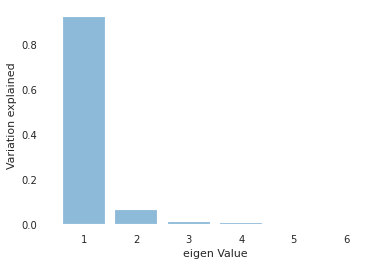

In [45]:
# plt.bar(list(range(1,7)),pca3.explained_variance_ratio_,alpha=0.5, align='center');
# plt.ylabel('Variation explained');
# plt.xlabel('eigen Value');
# plt.show();

In [46]:
# plt.step(list(range(1,7)),np.cumsum(pca3.explained_variance_ratio_), where='mid')
# plt.ylabel('Cum of variation explained')
# plt.xlabel('eigen Value')
# plt.show()